# Bronze Layer

## Data Ingestion

In [2]:
# Define environment variable
import os
S3_ACCESS_KEY = os.environ.get("MINIO_ACCESS_KEY")
S3_SECRET_KEY = os.environ.get("MINIO_SECRET_KEY")
S3_ENDPOINT = 'http://minio-bucket:9001'

## Config spark and create sparkSession for bronze

In [7]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("BronzeLayer")
    .master("local[*]")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-core_2.12:2.4.0")
    .config("spark.hadoop.fs.s3a.endpoint", S3_ENDPOINT)
    .config("spark.hadoop.fs.s3a.access.key", S3_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", S3_SECRET_KEY)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.connect.extensions.relation.classes","org.apache.spark.sql.connect.delta.DeltaRelationPlugin")
    .config("spark.connect.extensions.command.classes","org.apache.spark.sql.connect.delta.DeltaCommandPlugin")
    .config("spark.sql.parquet.compression.codec", "gzip")  # cannot use snappy -> glib error in some linux. Alternative: 'lzo' or 'gzip'
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") # https://docs.tecton.ai/docs/beta/tips-and-tricks/troubleshooting/conversion-from-pyspark-dataframe-to-pandas-dataframe-with-pandas-2-0
    .getOrCreate()
)

In [8]:
# define path
minio_bucket_path_b = "s3a://taxi/bronze"
minio_bucket_path_s = "s3a://taxi/silver"
minio_bucket_path_g = "s3a://taxi/gold"

## Ingest data from source

In [9]:
yellow_df = spark.read.parquet('/data/yellow_tripdata_2024-01.parquet')
green_df = spark.read.parquet('/data/green_tripdata_2024-01.parquet')

## Add Metadata Columns

In [196]:
from pyspark.sql.functions import current_date ,lit
yellow_df = (yellow_df
             .withColumn('ingest_date', current_date())
             .withColumn('source',lit('yellow'))
            )
green_df = (green_df
             .withColumn('ingest_date', current_date())
             .withColumn('source',lit('green'))
            )             


## Load to bronze layer

In [197]:
yellow_b_path = f"{minio_bucket_path_b}/yellow"
green_b_path = f"{minio_bucket_path_b}/green"
(yellow_df.write
    .format('delta')
    .mode('append')
    .option('mergeSchema','true') # Enable Schema Evolution
    .partitionBy('ingest_date')
    .save(yellow_b_path))

(green_df.write
    .format('delta')
    .mode('append')
    .option('mergeSchema','true') # Enable Schema Evolution
    .partitionBy('ingest_date')
    .save(green_b_path))

In [199]:
# done bronze pipeline
spark.stop()

# Explore Data

In [200]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("Exploring")
    .master("local[*]")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-core_2.12:2.4.0")
    .config("spark.hadoop.fs.s3a.endpoint", S3_ENDPOINT)
    .config("spark.hadoop.fs.s3a.access.key", S3_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", S3_SECRET_KEY)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.connect.extensions.relation.classes","org.apache.spark.sql.connect.delta.DeltaRelationPlugin")
    .config("spark.connect.extensions.command.classes","org.apache.spark.sql.connect.delta.DeltaCommandPlugin")
    .config("spark.sql.parquet.compression.codec", "gzip")  # Alternative: 'lzo' or 'uncompressed'
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") # https://docs.tecton.ai/docs/beta/tips-and-tricks/troubleshooting/conversion-from-pyspark-dataframe-to-pandas-dataframe-with-pandas-2-0
    .getOrCreate()
)

In [201]:
bronze_yellow_df = spark.read.format("delta").load(yellow_b_path)
bronze_green_df = spark.read.format("delta").load(green_b_path)

In [202]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
import pandas as pd

def display_all(df: DataFrame):
    # Describe numeric columns
    desc_stats = df.describe().toPandas()
    desc_stats.set_index("summary", inplace=True)

    # Unique count and null count for all columns
    unique_counts = df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df.columns)).toPandas().T
    unique_counts.columns = ["unique_count"]

    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T
    null_counts.columns = ["null_count"]

    # Combine all stats into a single DataFrame
    combined_stats = desc_stats.T.join(unique_counts).join(null_counts)
    combined_stats.index.name = "Column"

    # Display the result
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(combined_stats)

In [203]:
'''
Analysis
1. Significant null columns: 
    1.1 passenger_count 
    1.2 RatecodeID
    1.3 store_and_fwd_flag
    1.4 congestion_surcharge 
    1.5 Airport_fee
2. Outliers and Unrealistic values:
    2.1 trip_distance, fare_amount -> extreme outliers     
    2.2 Unrealistic values: 
        high unique count negative values:
            2.2.1 fare_amount
            2.2.2 total_amount
            2.2.3 tip_amount
            2.2.4 tolls_amount            
        low unique count negative values:             
            2.2.5 extra
            2.2.6 mta_tax
            2.2.7 improvement_surcharge
            2.2.8 congestion_surcharge
            2.2.9 Airport_fee
        2.2.10 passenger_count is 0        
3. Out range lookup table values
    3.1 VendorID range [1,2]
    3.2 RatecodeID range [1,6]
    3.3 payment_type range [1,6]    
'''
display_all(bronze_yellow_df)

,count,mean,stddev,min,max,unique_count,null_count
Column,,,,,,,
VendorID,2964624,1.7542042431013174,0.4325902017035929,1,6,3,0
passenger_count,2824462,1.3392808966805005,0.8502816924800934,0,9,10,140162
trip_distance,2964624,3.6521691789583177,225.46257238220025,0.0,312722.3,4489,0
RatecodeID,2824462,2.069359403666964,9.82321895279553,1,99,7,140162
store_and_fwd_flag,2824462,None,None,N,Y,2,140162
PULocationID,2964624,166.01788354948215,63.623914487412954,1,265,260,0
DOLocationID,2964624,165.11671227110082,69.31534978524839,1,265,261,0
payment_type,2964624,1.1612707041432573,0.5808685566109382,0,4,5,0
fare_amount,2964624,18.175061916790906,18.94954770590553,-899.0,5000.0,8970,0


### After analysis Implement cleaning method

### Function Implementation First Implemented

In [204]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col,abs,when
import warnings

# valid range
def clean_vendor_id(df: DataFrame, valid_range=(1, 2)) -> DataFrame:
    min_val, max_val = valid_range
    return df.filter((col("VendorID") >= min_val) & (col("VendorID") <= max_val))
# valid value
def clean_passenger_count(df: DataFrame) -> DataFrame:
    return df.filter(col("passenger_count") > 0)
# drop outliers using IQR
def clean_trip_distance(df: DataFrame) -> DataFrame:
    q1 = df.approxQuantile("trip_distance", [0.25], 0.05)[0]
    q3 = df.approxQuantile("trip_distance", [0.75], 0.05)[0]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.filter((col("trip_distance") >= lower_bound) & (col("trip_distance") <= upper_bound))
# valid range
def clean_ratecode_id(df: DataFrame, valid_range=(1, 6)) -> DataFrame:
    min_val, max_val = valid_range
    return df.filter((col("RatecodeID") >= min_val) & (col("RatecodeID") <= max_val))
# fill na
def clean_store_and_fwd_flag(df: DataFrame) -> DataFrame:
    return df.fillna({'store_and_fwd_flag': 'N'})
# less 1 than actual value  "mapping value from [1, 6] to [0, 5]."
def clean_payment_type(df: DataFrame) -> DataFrame:   
    return df.withColumn(
        "payment_type", 
        when(col("payment_type") < 0, None) 
        .when(col("payment_type") >= 0, col("payment_type") + 1) 
        .otherwise(None)  
    )  

def clean_negative_values(df: DataFrame, columns: list[str]) -> DataFrame:
    for column in columns:
        df = df.withColumn(column,when(col(column) < 0, abs(col(column))).otherwise(col(column)))
    return df
def clean_yellow_data(df: DataFrame) -> DataFrame:
    df = clean_vendor_id(df)
    df = clean_passenger_count(df)
    df = clean_trip_distance(df)
    df = clean_ratecode_id(df)
    df = clean_store_and_fwd_flag(df)
    df = clean_payment_type(df)
    negative_value_columns = [
        "fare_amount", "extra", "mta_tax", "tip_amount",
        "tolls_amount", "improvement_surcharge", 
        "total_amount", "congestion_surcharge", "Airport_fee"
    ]
    df = clean_negative_values(df, negative_value_columns)
    return df

### Function Implementation With more reusable

In [238]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col,abs,when,to_timestamp,unix_timestamp,lit
import warnings
import re 
def to_snake_case(text: str) -> str:
    '''
    Converts string to snake case
    Parameters:
    - text: string to be converted to snake case
    Return:
    - string in snake case
    '''
    #spaces and hyphens 
    text = re.sub(r"[\s-]+", "_", text)
    #Underscore before uppercase letters that follow a lowercase or number
    text = re.sub(r"(?<=[a-z0-9])([A-Z])", r"_\1", text)    
    return text.lower()

def rename_columns_to_snake_case(df: DataFrame) -> DataFrame:
    '''
    Rename columns to snake case
    Parameters: 
    - df: DataFrame to be rename columns to snake case
    Return: 
    - DataFrame with snake case columns
    '''
    for col_name in df.columns:
        df = df.withColumnRenamed(col_name, to_snake_case(col_name))
    return df

def check_columns_exist(df: DataFrame, columns: list[str]) -> list[str]:
    '''
    Check if the specified columns exist in the DataFrame and return a list of existing columns.
    Parameters:
    - df: DataFrame to be checked
    - columns: list of columns to be checked
    Return:
    - list of existing columns
    '''
    existing_columns = [column for column in columns if column in df.columns]
    missing_columns = set(columns) - set(existing_columns)
    if missing_columns:
        warnings.warn(f"Warning: Columns not found and will be skipped: {', '.join(missing_columns)}")
    return existing_columns

# Utils function
def filter_valid_range(df: DataFrame,
                       columns_ranges: dict[str, tuple[int, int]]
                       ) -> DataFrame:
    '''
    Filter rows based on valid range
    Parameters:
    - df: DataFrame to be filtered
    - columns_ranges: dictionary of column names(key) and valid ranges(value)
    Return:
    - DataFrame with valid rows
    '''
    for column, (min_val, max_val) in columns_ranges.items():
        if column in df.columns:
            df = df.filter((col(column) >= min_val) & (col(column) <= max_val))
        else:
            warnings.warn(f"Warning: Column '{column}' not found and will be skipped.")
    return df

def filter_positive (df:DataFrame,columns:list[str]) -> DataFrame:
    '''
    Filter positive values
    Parameters:
    - df: DataFrame to be filtered
    - columns: list of columns to be filtered
    Return:
    - DataFrame with positive values
    '''
    columns = check_columns_exist(df, columns)
    for column in columns:
        df = df.filter(col(column) > 0)
    return df

def filter_iqr_outliers(df:DataFrame,columns:list[str]) -> DataFrame:
    '''
    Filter outliers using IQR
    Parameters:
    - df: DataFrame to be filtered
    - columns: list of columns to be filtered
    Return:
    - DataFrame with outliers filtered
    '''
    columns = check_columns_exist(df, columns)
    for column in columns:
        q1 = df.approxQuantile(column, [0.25], 0.05)[0]
        q3 = df.approxQuantile(column, [0.75], 0.05)[0]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    return df

def fill_na(df:DataFrame,columns:list[str],fill_value) -> DataFrame:
    '''
    Fill missing values
    Parameters:
    - df: DataFrame to be filled
    - columns: list of columns to be filled 
    - fill_value: value to be filled
    Return:
    - DataFrame with missing values filled
    '''
    columns = check_columns_exist(df, columns)
    fill_dict = {column: fill_value for column in columns}
    return df.fillna(fill_dict)

def correct_negative_values(df: DataFrame, columns: list[str]) -> DataFrame:
    '''
    Replace negative values with absolute values
    Parameters:
    - df: DataFrame
    - columns: list of columns 
    Return:
    - DataFrame with corrected negative values
    '''
    columns = check_columns_exist(df, columns)    
    for column in columns:
        df = df.withColumn(column, when(col(column) < 0, abs(col(column))).otherwise(col(column)))
    return df

def filter_time_in_range(df: DataFrame, 
                         time_col: str ='tpep_pickup_datetime',                         
                         date_range: tuple[str, str] = ('2024-01-01', '2024-01-31')
                         ) -> DataFrame:
    '''
    Filter Dataframe by time range
    Parameters:
    - df: DataFrame to be filter
    - time_col: column of timestamp to be filter
    - date_range: tuple of start date and end date
    Return:
    - DataFrame with valid rows
    '''
    return df.filter(
                (col(time_col) >= lit(date_range[0])) & 
                (col(time_col) <= lit(date_range[1]))
                )
    
def drop_columns(df: DataFrame, columns: list[str]) -> DataFrame:
    '''
    Drop specified columns
    Parameters:
    - df: DataFrame to be dropped
    - columns: list of columns to be dropped
    Return:
    - DataFrame with dropped columns
    '''
    columns = check_columns_exist(df, columns)
    return df.drop(*columns)

# More Specific
def adjust_payment_type(df: DataFrame) -> DataFrame:
    '''
    Plus 1 to payment_type (In this case, shift payment_type from [0,5] to [1,6])
    Parameters:
    - df: DataFrame to be adjusted
    Return:
    - DataFrame with adjusted payment_type
    '''
    columns = ["payment_type"]
    columns = check_columns_exist(df,columns)
    for column in columns:
        df = df.withColumn(
            column, 
            when(col(column) < 0, None)
            .when(col(column) >= 0, col(column) + 1)
            .otherwise(None)
        )
    return df

def change_timestamp_format(df: DataFrame, 
                           pickup_col: str = 'tpep_pickup_datetime', 
                           dropoff_col: str = 'tpep_dropoff_datetime'                  
                            ) -> DataFrame:
    '''
    Create new column of timestamp from original timestamp columns
    Parameters:
    - df: DataFrame to be changed
    - pickup_col: column of pickup timestamp
    - dropoff_col: column of dropoff timestamp
    Return:
    - DataFrame with changed timestamp format
    '''
    if pickup_col in df.columns:
        df = df.withColumn(
            'pickup_datetime',
            to_timestamp(col(pickup_col),'yyyy-MM-dd HH:mm:ss')
        ).drop(pickup_col)        
    else:        
        warnings.warn(f"Warning: Column '{pickup_col}' not found and will be skipped.")    
    if dropoff_col in df.columns:
        df = df.withColumn(
            'dropoff_datetime',
            to_timestamp(col(dropoff_col),'yyyy-MM-dd HH:mm:ss')            
        ).drop(dropoff_col)
    else:        
        warnings.warn(f"Warning: Column '{dropoff_col}' not found and will be skipped.")  
    return df 
        
# enrichment function
def add_trip_duration(df: DataFrame, 
                      pickup_col: str = "pickup_datetime", 
                      dropoff_col: str = "dropoff_datetime"
                      ) -> DataFrame:
    '''
    Create new column of trip_duration(in minutes)
    Parameters:
    - df: DataFrame
    - pickup_col: column of pickup timestamp
    - dropoff_col: column of dropoff timestamp
    Return:
    - DataFrame with added trip_duration
    '''
    if pickup_col in df.columns and dropoff_col in df.columns:
        df = df.withColumn(
            "trip_duration",
            (unix_timestamp(col(dropoff_col)) - unix_timestamp(col(pickup_col))) / 60
        )
    else:
        warnings.warn(f"Warning: Columns '{pickup_col}' or '{dropoff_col}' not found and will be skipped.")    
    return df
    
def add_fare_per_mile(df: DataFrame, fare_col: str = "fare_amount", distance_col: str = "trip_distance") -> DataFrame:
    '''
    Create new column of fare_per_mile (fare_amount / trip_distance)
    Parameters:
    - df: DataFrame
    - fare_col: column of fare_amount
    - distance_col: column of trip_distance
    Return:
    - DataFrame with added fare_per_mile
    '''
    if fare_col in df.columns and distance_col in df.columns:
        df = df.withColumn(
            "fare_per_mile",
            when(col(distance_col) > 0, col(fare_col) / col(distance_col)).otherwise(0)
        )
    else:
        print(f"Warning: '{fare_col}' or '{distance_col}' column is missing. 'fare_per_mile' column not added.")
    
    return df

### Display after cleaned

In [206]:
clean_yellow_df = clean_yellow_data(bronze_yellow_df)

In [207]:
display_all(clean_yellow_df)

,count,mean,stddev,min,max,unique_count,null_count
Column,,,,,,,
VendorID,2397569,1.769572846495763,0.42110634570713756,1,2,2,0
passenger_count,2397569,1.349706723768951,0.8446910271937808,1,9,9,0
trip_distance,2397569,1.7485779762752183,1.1622812685392787,0.0,5.87,588,0
RatecodeID,2397569,1.0281818792285018,0.3194787636076222,1,6,6,0
store_and_fwd_flag,2397569,None,None,N,Y,2,0
PULocationID,2397569,170.02536402497697,64.23690141614979,1,265,247,0
DOLocationID,2397569,168.63152259642996,67.6970968726364,1,265,251,0
payment_type,2397569,2.218237306204743,0.5323054555207001,2,5,4,0
fare_amount,2397569,13.119691937958514,8.70797336382297,0.0,820.0,1584,0


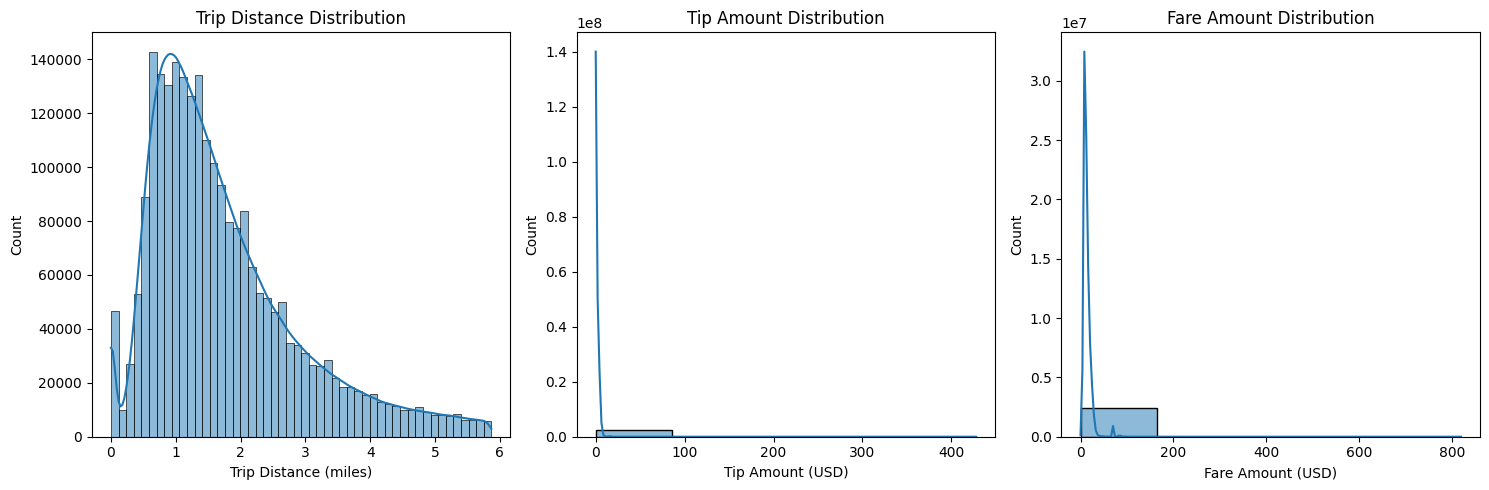

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = clean_yellow_df.select("trip_distance", "tip_amount", "fare_amount").toPandas()

# Plot trip_distance distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['trip_distance'], kde=True, bins=50)
plt.title("Trip Distance Distribution")
plt.xlabel("Trip Distance (miles)")

# Plot tip_amount distribution
plt.subplot(1, 3, 2)
sns.histplot(df['tip_amount'], kde=True, bins=5)
plt.title("Tip Amount Distribution")
plt.xlabel("Tip Amount (USD)")

# Plot fare_amount distribution
plt.subplot(1, 3, 3)
sns.histplot(df['fare_amount'], kde=True, bins=5)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount (USD)")

plt.tight_layout()
plt.show()


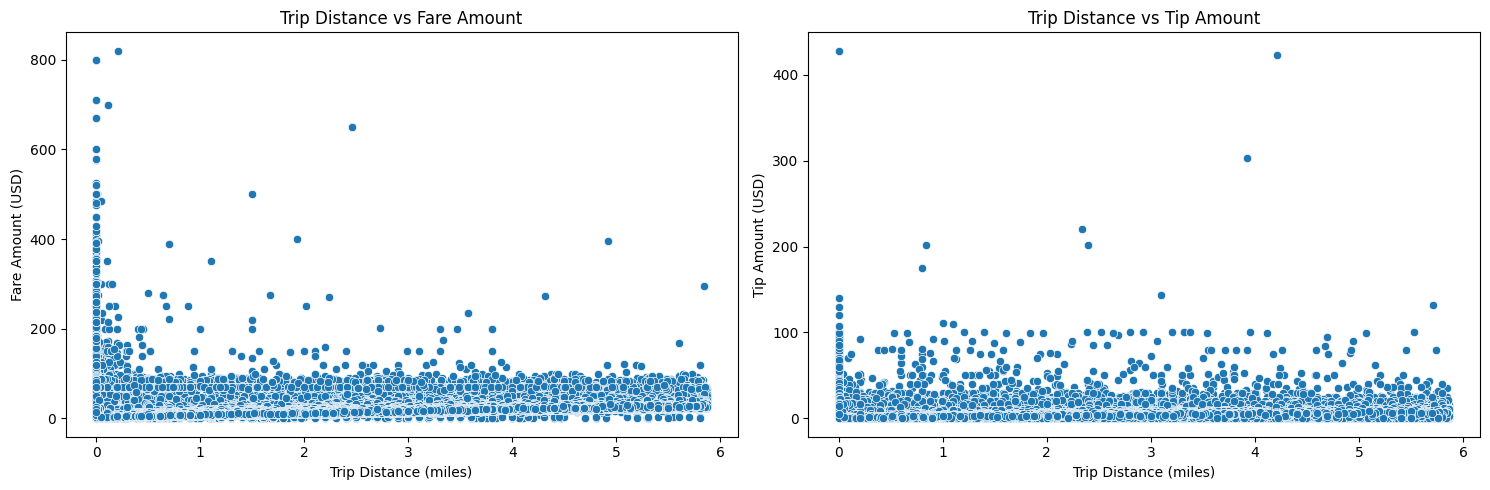

In [209]:
# Scatter plot for trip_distance vs fare_amount
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=df['trip_distance'], y=df['fare_amount'])
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount (USD)")

# Scatter plot for trip_distance vs tip_amount
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['trip_distance'], y=df['tip_amount'])
plt.title("Trip Distance vs Tip Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount (USD)")

plt.tight_layout()
plt.show()



In [210]:
'''
Analysis
1. Significant null columns: 
    1.1 store_and_fwd_flag 
    1.2 RatecodeID 
    1.3 passenger_count 
    1.4 ehail_fee 
    1.5 payment_type 
    1.6 trip_type 
    1.7 congestion_surcharge 
2. Outliers and Unrealistic value:
    2.1 trip_distance 
    2.2 fare_amount
    2.3 tip_amount
    2.4 tolls_amount
    2.5 congestion_surcharge
3. Out of range value:
    3.1 RatecodeID range [1,6]
    3.2 payment_type range [1,5]
'''
display_all(bronze_green_df)

,count,mean,stddev,min,max,unique_count,null_count
Column,,,,,,,
VendorID,56551,1.8702410213789322,0.33604104352490644,1,2,2,0
store_and_fwd_flag,53136,None,None,N,Y,2,3415
RatecodeID,53136,1.1516109605540499,1.0452509665964087,1,99,6,3415
PULocationID,56551,96.07759367650439,57.86240111469351,1,265,211,0
DOLocationID,56551,140.4998496931973,76.55627585703567,1,265,241,0
passenger_count,53136,1.3091689250225835,0.9782520125657749,0,9,9,3415
trip_distance,56551,31.491123941221307,1417.4603816839042,0.0,201421.68,1890,0
fare_amount,56551,16.929275167547825,15.356031505227904,-70.0,1422.6,2225,0
extra,56551,0.9009469328570671,1.344313279188972,-5.0,10.25,17,0


# Silver Layer

## Config spark and create sparkSession for Silver

In [211]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("SilverLayer")
    .master("local[*]")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-core_2.12:2.4.0")
    .config("spark.hadoop.fs.s3a.endpoint", S3_ENDPOINT)
    .config("spark.hadoop.fs.s3a.access.key", S3_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", S3_SECRET_KEY)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.connect.extensions.relation.classes","org.apache.spark.sql.connect.delta.DeltaRelationPlugin")
    .config("spark.connect.extensions.command.classes","org.apache.spark.sql.connect.delta.DeltaCommandPlugin")
    .config("spark.sql.parquet.compression.codec", "gzip")  # Alternative: 'lzo' or 'uncompressed'
    .getOrCreate()
)

24/11/05 16:04:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Read Data from bronze layer

In [212]:
'''
Schema of Yellow taxi
VendorID 
    1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
pickup_datetime
dropoff_datetime
Passenger_count 
Trip_distance
PULocationID 
DOLocationID
RateCodeID 
    1= Standard rate
    2=JFK
    3=Newark
    4=Nassau or Westchester
    5=Negotiated fare
    6=Group ride
Store_and_fwd_flag 
Payment_type 
    1= Credit card
    2= Cash
    3= No charge
    4= Dispute
    5= Unknown
    6= Voided trip
Fare_amount 
Extra 
MTA_tax
Improvement_surcharge
Tip_amount
Tolls_amount
Total_amount
Congestion_Surcharge
Airport_fee
'''
bronze_raw_yellow_df = spark.read.format("delta").load(yellow_b_path)
bronze_raw_green_df = spark.read.format("delta").load(green_b_path)

## Data Cleansing,Validation and Enrichment

In [213]:
valid_ranges = {
    "VendorID": (1, 2),
    "RatecodeID": (1, 6),
    "payment_type": (1, 5),    
}
# 1.remove duplicate (distinct = all columns) 
bronze_yellow_df = bronze_raw_yellow_df.distinct()
# 2. filter valid range
bronze_yellow_df =  filter_valid_range(bronze_yellow_df, valid_ranges)
bronze_yellow_df =  filter_time_in_range(bronze_yellow_df)
# 3. filter out negative value (in some columns)
bronze_yellow_df = filter_positive(bronze_yellow_df, ["passenger_count","trip_distance"])
# 4. filter outlier
bronze_yellow_df = filter_iqr_outliers(bronze_yellow_df, ["trip_distance"])
# 5. fill null and correct value
bronze_yellow_df = fill_na(bronze_yellow_df,["store_and_fwd_flag"], "N")
bronze_yellow_df = adjust_payment_type(bronze_yellow_df)
bronze_yellow_df = correct_negative_values(bronze_yellow_df,[
        "fare_amount", "extra", "mta_tax", "tip_amount",
        "tolls_amount", "improvement_surcharge", 
        "total_amount", "congestion_surcharge", "Airport_fee"
    ])
# 6. Standardize schema 
bronze_yellow_df = rename_columns_to_snake_case(bronze_yellow_df)
cleaned_yellow_df = change_timestamp_format(bronze_yellow_df)
# 7. Data Enrichment
enriched_yellow_df = add_trip_duration(cleaned_yellow_df)
enriched_yellow_df = add_fare_per_mile(enriched_yellow_df)
enriched_yellow_df.show(10)


+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------+-------------------+-------------------+------------------+-----------------+
|vendor_id|passenger_count|trip_distance|ratecode_id|store_and_fwd_flag|pulocation_id|dolocation_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|ingest_date|source|    pickup_datetime|   dropoff_datetime|     trip_duration|    fare_per_mile|
+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------+-------------------+-------------------+------------------+-----------------+
|        2|     

In [214]:
valid_ranges = {
    "VendorID": (1, 2),
    "RatecodeID": (1, 6),
    "payment_type": (1, 5)
}
# 1 .drop unnecessary columns
bronze_green_df = drop_columns(bronze_raw_green_df, ["ehail_fee"])
# 2. remove duplicate
bronze_green_df = bronze_green_df.distinct()
# 3. filter valid range
bronze_green_df = filter_valid_range(bronze_green_df, valid_ranges)
bronze_green_df = filter_time_in_range(bronze_green_df,"lpep_pickup_datetime")
# 4. filter out negative value
bronze_green_df = filter_positive(bronze_green_df, ["passenger_count","trip_distance"])
# 5. filter outlier
bronze_green_df = filter_iqr_outliers(bronze_green_df, ["trip_distance"])
# 6. fill null and correct value
bronze_green_df = fill_na(bronze_green_df, ["store_and_fwd_flag"], "N")
bronze_green_df = adjust_payment_type(bronze_green_df)
bronze_green_df = correct_negative_values(bronze_green_df, [
    "fare_amount", "extra", "mta_tax", "tip_amount",
    "tolls_amount", "improvement_surcharge", 
    "total_amount", "congestion_surcharge", "Airport_fee"
])
# 7. Standardize schema
bronze_green_df = rename_columns_to_snake_case(bronze_green_df)
cleaned_green_df = change_timestamp_format(bronze_green_df, "lpep_pickup_datetime", "lpep_dropoff_datetime")

# 8. Data Enrichment
enriched_green_df = add_trip_duration(cleaned_green_df)
enriched_green_df = add_fare_per_mile(enriched_green_df)
enriched_green_df.show(10)


/tmp/ipykernel_79/3468123710.py:43: UserWarning: Warning: Columns not found and will be skipped: Airport_fee
  warnings.warn(f"Warning: Columns not found and will be skipped: {', '.join(missing_columns)}")


+---------+------------------+-----------+-------------+-------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+-----------+------+-------------------+-------------------+-------------------+------------------+
|vendor_id|store_and_fwd_flag|ratecode_id|pulocation_id|dolocation_id|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|ingest_date|source|    pickup_datetime|   dropoff_datetime|      trip_duration|     fare_per_mile|
+---------+------------------+-----------+-------------+-------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+-----------+------+-------------------+-------------------+-------------------+------------------+
|        1|     

## Create Look Up table (Dimension Table)

In [215]:
from pyspark import SparkFiles
# 1. Vendor Dimension Table
vendor_data = [
    (1, "Creative Mobile Technologies, LLC"),
    (2, "VeriFone Inc.")
]
vendor_df = spark.createDataFrame(vendor_data, ["vendor_id", "vendor_name"])

# 2. RateCode Dimension Table
rate_code_data = [
    (1, "Standard rate"),
    (2, "JFK"),
    (3, "Newark"),
    (4, "Nassau or Westchester"),
    (5, "Negotiated fare"),
    (6, "Group ride")
]
rate_code_df = spark.createDataFrame(rate_code_data, ["rate_code_id", "rate_description"])

# 3. Location Dimension Table (assuming PULocationID/DOLocationID maps to Taxi Zones)
lookup_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"
spark.sparkContext.addFile(lookup_url)
location_df = spark.read.csv(f'file://{SparkFiles.get("taxi_zone_lookup.csv")}', header=True, inferSchema=True)
location_df = rename_columns_to_snake_case(location_df)

# Paths for saving dimension tables
dim_vendor_path = "s3a://taxi/silver/dim_vendor"
dim_rate_code_path = "s3a://taxi/silver/dim_rate_code"
dim_location_path = "s3a://taxi/silver/dim_location"

# Save dimension tables in Delta format
vendor_df.write.format("delta").mode("overwrite").save(dim_vendor_path)
rate_code_df.write.format("delta").mode("overwrite").save(dim_rate_code_path)
location_df.write.format("delta").mode("overwrite").save(dim_location_path)


In [216]:
location_df.printSchema()

root
 |-- location_id: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [217]:
rate_code_df.printSchema()

root
 |-- rate_code_id: long (nullable = true)
 |-- rate_description: string (nullable = true)



In [218]:
vendor_df.printSchema()

root
 |-- vendor_id: long (nullable = true)
 |-- vendor_name: string (nullable = true)



## Load to Silver

In [219]:
silver_yellow_path = "s3a://taxi/silver/yellow"
silver_green_path = "s3a://taxi/silver/green"
(
    enriched_yellow_df
    .write
    .format("delta")
    .mode("append")
    .partitionBy("ingest_date")
    .save(silver_yellow_path)
)
(
    enriched_green_df
    .write
    .format("delta")
    .mode("append")
    .partitionBy("ingest_date")
    .save(silver_green_path)
)

In [220]:
enriched_yellow_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecode_id: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- pulocation_id: integer (nullable = true)
 |-- dolocation_id: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- ingest_date: date (nullable = true)
 |-- source: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- fare_per_m

In [221]:
enriched_green_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- ratecode_id: long (nullable = true)
 |-- pulocation_id: integer (nullable = true)
 |-- dolocation_id: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- trip_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- ingest_date: date (nullable = true)
 |-- source: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- fare_per_mile:

In [222]:
spark.stop()

# Gold Layer

## Config spark and create sparkSession for gold

In [223]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("GoldLayer")
    .master("local[*]")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-core_2.12:2.4.0")
    .config("spark.hadoop.fs.s3a.endpoint", S3_ENDPOINT)
    .config("spark.hadoop.fs.s3a.access.key", S3_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", S3_SECRET_KEY)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.connect.extensions.relation.classes","org.apache.spark.sql.connect.delta.DeltaRelationPlugin")
    .config("spark.connect.extensions.command.classes","org.apache.spark.sql.connect.delta.DeltaCommandPlugin")
    .config("spark.sql.parquet.compression.codec", "gzip")  # Set Alternative: 'lzo','gzip' for snappy(no glib error) https://medium.com/@ashwin_kumar_/gzip-snappy-and-lzo-compression-formats-in-spark-3b82a566bc7d
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") # https://docs.tecton.ai/docs/beta/tips-and-tricks/troubleshooting/conversion-from-pyspark-dataframe-to-pandas-dataframe-with-pandas-2-0
    .config("delta.autoOptimize.optimizeWrite", "true")
    .getOrCreate()
)

## Ingest data from Silver

In [224]:
silver_yellow_path = "s3a://taxi/silver/yellow"
silver_raw_yellow_df = spark.read.format("delta").load(silver_yellow_path)
silver_raw_yellow_df.show(5)

+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------+-------------------+-------------------+-------------------+------------------+
|vendor_id|passenger_count|trip_distance|ratecode_id|store_and_fwd_flag|pulocation_id|dolocation_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|ingest_date|source|    pickup_datetime|   dropoff_datetime|      trip_duration|     fare_per_mile|
+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------+-------------------+-------------------+-------------------+------------------+
|        2

In [225]:
silver_green_path = "s3a://taxi/silver/green"
silver_raw_green_df = spark.read.format("delta").load(silver_green_path)
silver_raw_green_df.show(5)

+---------+------------------+-----------+-------------+-------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+-----------+------+-------------------+-------------------+------------------+-----------------+
|vendor_id|store_and_fwd_flag|ratecode_id|pulocation_id|dolocation_id|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|ingest_date|source|    pickup_datetime|   dropoff_datetime|     trip_duration|    fare_per_mile|
+---------+------------------+-----------+-------------+-------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+-----------+------+-------------------+-------------------+------------------+-----------------+
|        2|           

## Aggregation and Summarization

### gold_yellow_taxi_daily_summary
Columns: date, total_trips, total_fare_amount, average_trip_distance, average_trip_duration

In [226]:
from pyspark.sql import functions as F
daily_summary_df = (silver_raw_yellow_df  
    .groupBy(F.to_date("pickup_datetime").alias("date")) 
        .agg(
            F.count("*").alias("total_trips"),
            F.sum("fare_amount").alias("total_fare_amount"),
            F.avg("trip_distance").alias("average_trip_distance"),
            F.avg("trip_duration").alias("average_trip_duration")
        ).sort("date")
)
daily_summary_df.show(31)

+----------+-----------+------------------+---------------------+---------------------+
|      date|total_trips| total_fare_amount|average_trip_distance|average_trip_duration|
+----------+-----------+------------------+---------------------+---------------------+
|2024-01-01|      55084| 758859.3199999996|   2.0788562922082674|   13.128968484496397|
|2024-01-02|      57160| 734364.5300000029|   1.8389462911126724|   12.140507639374851|
|2024-01-03|      64895| 831354.2299999971|   1.8225006549040772|   12.106988725376914|
|2024-01-04|      84595| 1130303.909999999|   1.8799385306460186|   12.825788561183694|
|2024-01-05|      85332| 1116877.070000003|   1.8710759152486747|   12.459746441350651|
|2024-01-06|      79106|1005984.8399999975|   1.8458707304123532|   12.128316225486483|
|2024-01-07|      51779| 630909.1800000004|    1.859490333919159|    10.71689681144865|
|2024-01-08|      63718| 800679.7900000003|   1.8033513292947077|   11.685456490578296|
|2024-01-09|      74681| 939221.

In [227]:
# load


### gold_daily_source_metrics
columns: date,  
green_avg_fare, green_min_fare, green_max_fare,  
green_avg_trip_distance, green_min_trip_distance, green_max_trip_distance, green_total_trips,  
yellow_avg_fare, yellow_min_fare, yellow_max_fare,  
yellow_avg_trip_distance, yellow_min_trip_distance, yellow_max_trip_distance, yellow_total_trips  

#### Combine Green and Yellow With Intersect columns

In [228]:
common_col = [_ for _ in silver_raw_yellow_df.columns if _ in silver_raw_green_df.columns]
common_col

['vendor_id',
 'passenger_count',
 'trip_distance',
 'ratecode_id',
 'store_and_fwd_flag',
 'pulocation_id',
 'dolocation_id',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'ingest_date',
 'source',
 'pickup_datetime',
 'dropoff_datetime',
 'trip_duration',
 'fare_per_mile']

In [229]:
# Select common columns
silver_raw_yellow_df = silver_raw_yellow_df.select(common_col)
silver_raw_green_df = silver_raw_green_df.select(common_col)
silver_raw_yellow_df.show(3)
silver_raw_green_df.show(3)

+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------+-------------------+-------------------+-------------------+------------------+
|vendor_id|passenger_count|trip_distance|ratecode_id|store_and_fwd_flag|pulocation_id|dolocation_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|ingest_date|source|    pickup_datetime|   dropoff_datetime|      trip_duration|     fare_per_mile|
+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------+-------------------+-------------------+-------------------+------------------+
|        2|              1|         0.04|     

In [230]:
combined_df = silver_raw_yellow_df.unionByName(silver_raw_green_df)
combined_df.show(5)

+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------+-------------------+-------------------+-------------------+------------------+
|vendor_id|passenger_count|trip_distance|ratecode_id|store_and_fwd_flag|pulocation_id|dolocation_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|ingest_date|source|    pickup_datetime|   dropoff_datetime|      trip_duration|     fare_per_mile|
+---------+---------------+-------------+-----------+------------------+-------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------+-------------------+-------------------+-------------------+------------------+
|        2|              1|         0.04|     

#### Pivot on source to compare between Green and Yellow taxis (Metric fare_amount,trip_distance)

In [231]:
from pyspark.sql import functions as F
service_comparison = (combined_df
        .groupBy(F.to_date("pickup_datetime").alias("date")) 
        .pivot("source") 
        .agg(
            F.avg("fare_amount").alias("avg_fare"),  
            F.min("fare_amount").alias("min_fare"),
            F.max("fare_amount").alias("max_fare"),      
            F.avg("trip_distance").alias("avg_trip_distance"),
            F.min("trip_distance").alias("min_trip_distance"),
            F.max("trip_distance").alias("max_trip_distance"),
            F.count("*").alias("total_trips")
        ).sort("date")
    )

In [232]:
service_comparison.show(31)

+----------+------------------+--------------+--------------+-----------------------+-----------------------+-----------------------+-----------------+------------------+---------------+---------------+------------------------+------------------------+------------------------+------------------+
|      date|    green_avg_fare|green_min_fare|green_max_fare|green_avg_trip_distance|green_min_trip_distance|green_max_trip_distance|green_total_trips|   yellow_avg_fare|yellow_min_fare|yellow_max_fare|yellow_avg_trip_distance|yellow_min_trip_distance|yellow_max_trip_distance|yellow_total_trips|
+----------+------------------+--------------+--------------+-----------------------+-----------------------+-----------------------+-----------------+------------------+---------------+---------------+------------------------+------------------------+------------------------+------------------+
|2024-01-01|13.654888641425394|           3.0|         135.0|      2.052906458797326|                   0.01|

In [233]:
# drop day 31 due green taxi has no data on 2024-01-31
service_comparison = service_comparison.filter(service_comparison.date != '2024-01-31')
service_comparison.show(31)

+----------+------------------+--------------+--------------+-----------------------+-----------------------+-----------------------+-----------------+------------------+---------------+---------------+------------------------+------------------------+------------------------+------------------+
|      date|    green_avg_fare|green_min_fare|green_max_fare|green_avg_trip_distance|green_min_trip_distance|green_max_trip_distance|green_total_trips|   yellow_avg_fare|yellow_min_fare|yellow_max_fare|yellow_avg_trip_distance|yellow_min_trip_distance|yellow_max_trip_distance|yellow_total_trips|
+----------+------------------+--------------+--------------+-----------------------+-----------------------+-----------------------+-----------------+------------------+---------------+---------------+------------------------+------------------------+------------------------+------------------+
|2024-01-01|13.654888641425394|           3.0|         135.0|      2.052906458797326|                   0.01|

#### Basic Visualization

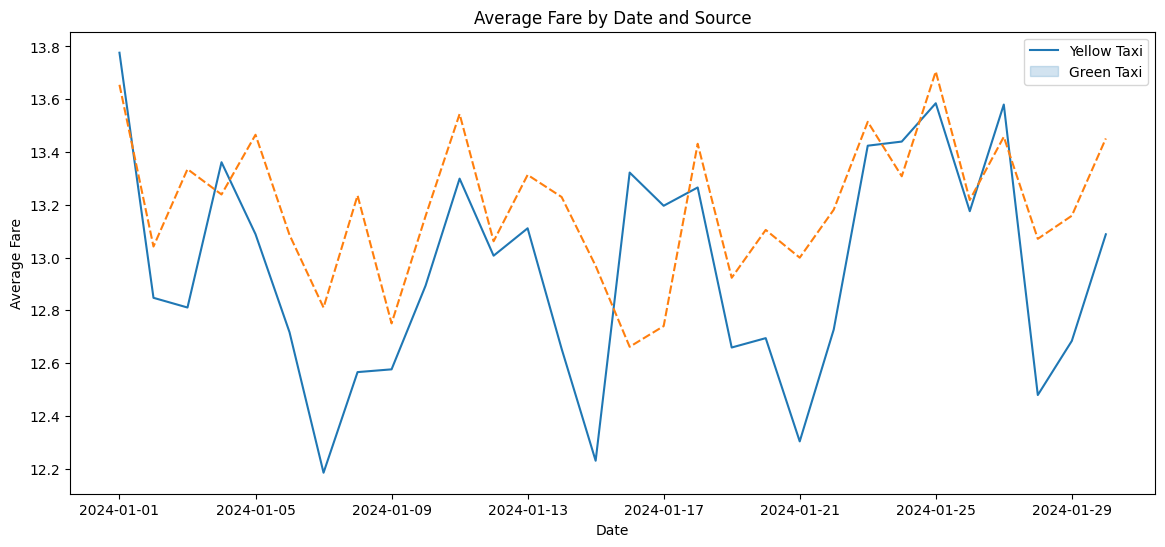

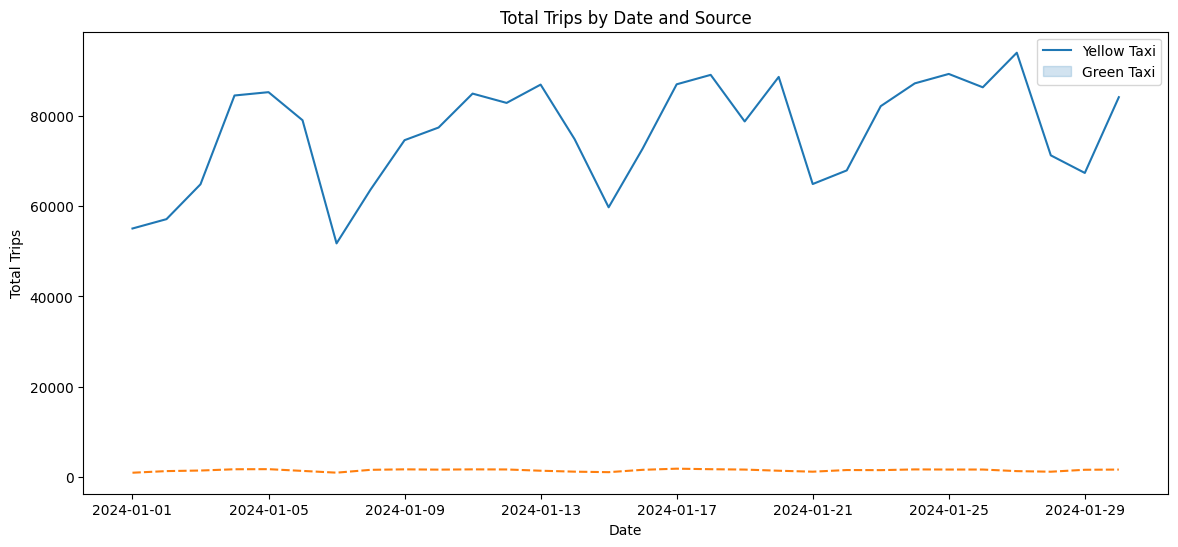

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame
service_comparison_pd = service_comparison.toPandas()

# Set date column as the index for easier plotting
service_comparison_pd['date'] = pd.to_datetime(service_comparison_pd['date'])
service_comparison_pd.set_index('date', inplace=True)

# Plot average fare over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=service_comparison_pd[['yellow_avg_fare', 'green_avg_fare']])
plt.title("Average Fare by Date and Source")
plt.ylabel("Average Fare")
plt.xlabel("Date")
plt.legend(["Yellow Taxi", "Green Taxi"])
plt.show()

# Plot total trips over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=service_comparison_pd[['yellow_total_trips', 'green_total_trips']])
plt.title("Total Trips by Date and Source")
plt.ylabel("Total Trips")
plt.xlabel("Date")
plt.legend(["Yellow Taxi", "Green Taxi"])
plt.show()


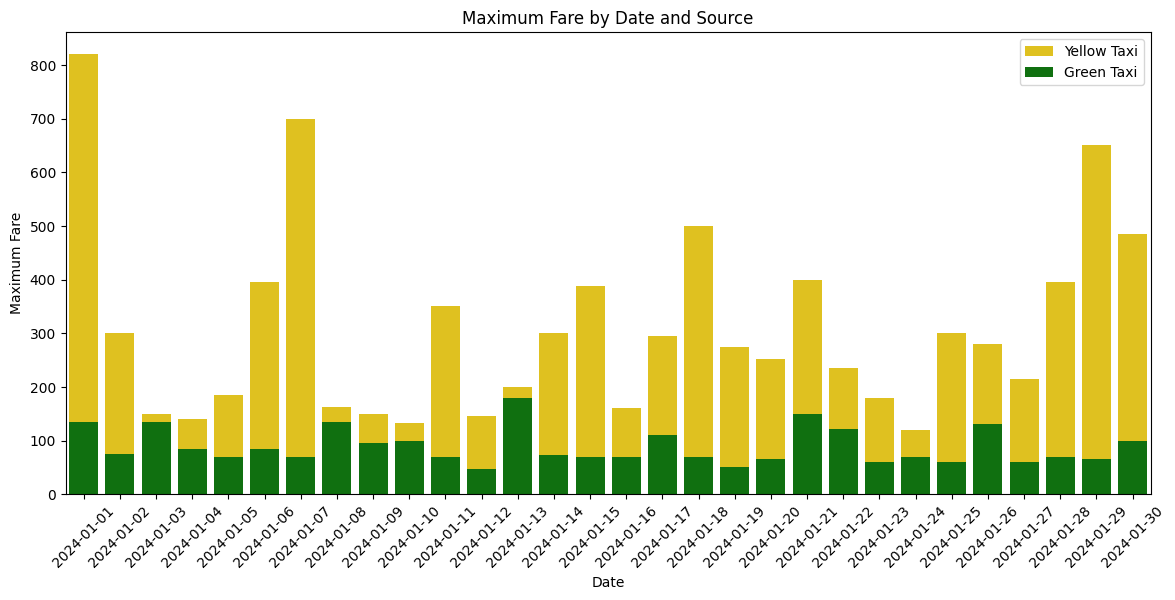

In [235]:
plt.figure(figsize=(14, 6))
sns.barplot(data=service_comparison_pd, x=service_comparison_pd.index, 
            y='yellow_max_fare', color="gold", label="Yellow Taxi")
sns.barplot(data=service_comparison_pd, x=service_comparison_pd.index, 
            y='green_max_fare', color="green", label="Green Taxi")
plt.title("Maximum Fare by Date and Source")
plt.ylabel("Maximum Fare")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Load to gold

In [236]:
gold_daily_yellow_summary = "s3a://taxi/gold/daily_yellow_summary"
(daily_summary_df.write
    .format("delta")
    .mode("overwrite")
    .partitionBy("date")
    .save(gold_daily_yellow_summary))
spark.sql(f"OPTIMIZE delta.`{gold_daily_yellow_summary}`")

gold_daily_source_metrics = "s3a://taxi/gold/daily_source_metrics"
(service_comparison.write
    .format("delta")
    .mode("overwrite")
    .partitionBy("date")
    .save(gold_daily_source_metrics))
spark.sql(f"OPTIMIZE delta.`{gold_daily_source_metrics}`")

DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [237]:
spark.stop()